In [1]:
%env CUDA_VISIBLE_DEVICES=

env: CUDA_VISIBLE_DEVICES=


In [2]:
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from megnet.models import MEGNetModel
from megnet_graphs_train import generate_paper_experiments

In [3]:
experiments = generate_paper_experiments()

In [4]:
global_save_path = os.path.join("datasets", "paper_experiments")
predictions_save_path = os.path.join(global_save_path, "results")
plots_path = os.path.join(global_save_path, "plots")

In [5]:
# Assumes all experiments are on the same data and use the fold defenitions!
data = pd.read_pickle(experiments[0].data_path)
folds = pd.read_csv(experiments[0].folds_path, squeeze=True, index_col="_id")

def process_experiment(experiment):
  assert experiment.data_path == experiments[0].data_path
  assert experiment.folds_path == experiments[0].folds_path  
  model = MEGNetModel.from_file(os.path.join(experiment.model_path))
  return model.predict_structures(data.defect_representation)

In [6]:
from multiprocessing import Pool
with Pool(20) as p:
  predictions = p.map(process_experiment, experiments)

In [7]:
def get_test_prediction_column(target):
  return f"test_predicted_{target}"

In [8]:
maes = defaultdict(list)
columns_to_save = set()
for experiment, this_predictions in zip(experiments, predictions):
  test_prediction_column = get_test_prediction_column(experiment.target)
  columns_to_save.add(test_prediction_column)
  predictions_pd = pd.Series(data=this_predictions.ravel(), index=data.index)
  train_prediction_column = f"train_fold_-{experiment.test_fold}_predicted_{experiment.target}"
  columns_to_save.add(train_prediction_column)
  
  test_ids = folds[folds == experiment.test_fold].index
  train_ids = folds[folds != experiment.test_fold].index
  
  data.loc[test_ids, test_prediction_column] = predictions_pd.loc[test_ids]
  data.loc[train_ids, train_prediction_column] = predictions_pd.loc[train_ids]
  maes[experiment.target].append(np.mean(np.abs(
    predictions_pd.loc[test_ids] - data.loc[test_ids, experiment.target])))

In [9]:
targets = set(map(lambda e: e.target, experiments))

In [10]:
def plot_target(target, data_name):
  fig, ax = plt.subplots()
  mae = np.mean(maes[target])
  mae_std = np.std(maes[target])
  test_prediction_column = get_test_prediction_column(target)
  ax.scatter(data.loc[:, target], data.loc[:, test_prediction_column],
             label=f"{data_name}, $MAE={mae:.4f} \pm {mae_std:.4f}$",
             alpha=0.5)
  
  ax.set_xlabel(f"DFT {target}, eV")
  ax.set_ylabel(f"Predicted {target}, eV")
  ax.legend()

  lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),
    np.max([ax.get_xlim(), ax.get_ylim()]),
  ]

  ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
  ax.set_aspect('equal')
  ax.set_xlim(lims)
  ax.set_ylim(lims)
  fig.savefig(os.path.join(plots_path, f"{target}_{data_name}.pdf"),
              bbox_inches="tight",
              metadata={
                "Author": "Nikita Kazeev",
                "Title": f"MEGNet on defect-only representation, {target}, {data_name}",
                "Keywords": "2D materials, machine learning, graph neural network, MEGNet"}
             )

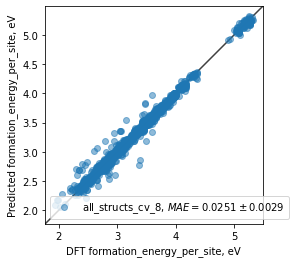

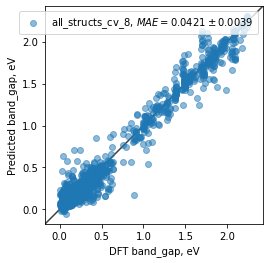

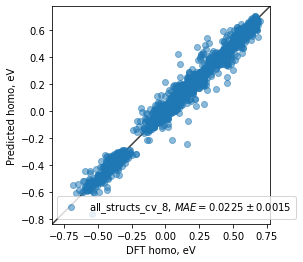

In [11]:
for target in targets:
  plot_target(target, "all_structs_cv_8")

In [12]:
data.to_csv(os.path.join(predictions_save_path, "full.csv.gz"),
            columns=columns_to_save, index_label="_id")